以下為正式的最佳化分類運作

In [ ]:
import smote_variants as sv
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import statistics
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
import math
from sklearn import metrics
from sklearn.cluster import KMeans  
from sklearn.cluster import AffinityPropagation
from collections import Counter
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as pl
from sklearn import svm

In [2019]:
# 引入資料
path = "/Users/emily/Desktop/Research/oversampling_python/data/"
folderName = 'abalone19-5-fold'#'abalone19-5-fold' # yeast6-5-fold'#'haberman-5-fold' #'abalone19-5-fold' # pima-5-fold yeast-2_vs_8-5-fold

os.chdir(path+ folderName)
dirs = os.listdir(path+ folderName)
train = []
test = []

for i in dirs:
    #print(i.split("-")[-1])
    if("xlsx" in i):
        if("tra" in i):
            train.append(i)

        elif("tst" in i):
            test.append(i)
train = sorted(train)
test = sorted(test)

In [ ]:
# 計算要補多少值
def find_maj(sample_class): # 給 class 資料
    counter = Counter(sample_class);
    maj = list(dict(counter.most_common(1)).keys())
    maj = "".join(maj)
    #print(maj)
    return  maj


def classprocess(output):
    c = Counter(output)
    datagap = []
    maj = find_maj(output)
    maj_num = dict(c)[find_maj(output)]
    for className, number in c.items(): 
        #print(className," ",number)
     #   print(number)
        temp = np.array([className,(maj_num - number)])
        datagap.append(temp)
    return datagap

2021-07-12 15:22:34,029:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")
原本 0
原本 3287
2021-07-12 15:22:39,570:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")
原本 0
原本 3287
2021-07-12 15:22:45,572:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")
原本 0
原本 3289
2021-07-12 15:22:51,104:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")
原本 0
原本 3289
2021-07-12 15:22:56,748:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': None}")
原本 0
原本 3288


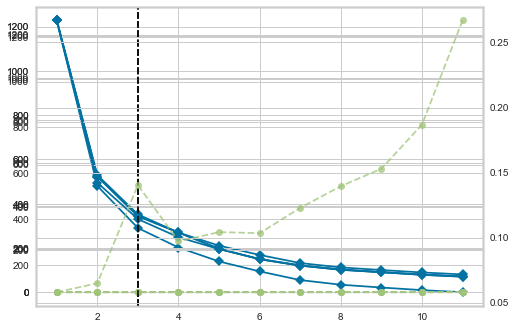

In [2021]:
# Cluster 最佳化群數後 各群的群中心
# polynom_fit_SMOTE
alloverpolynom = []
overpolynom = []

centerpolynom = []
countfor = 0;

for ii,i in enumerate(train):
    randomIndex = []
    le = preprocessing.LabelEncoder()
    data = pd.read_excel(i,index_col=0)
    lastColumn = data.columns[-1]
    
    data[lastColumn]= data[lastColumn].str.replace("\n", "").str.strip()
    originlen = data.shape[0] # 原始資料的筆數
    output = data.iloc[:,-1];
    classCount = classprocess(output) # 各類別差距
    finaldata = data.iloc[:,:-1]

    output = le.fit_transform(output)
    finaldata.iloc[:,0] = le.fit_transform(finaldata.iloc[:,0])
    
    #output.iloc[:] = le.fit_transform(output.iloc[:])

    tempover = []
    #print("origin",Counter(output)) # 原始的分類狀況
    finaldata = np.array(finaldata)
    output = np.array(output)
    over = sv.polynom_fit_SMOTE() # 產生數據
    
    X_polynom,y_polynom = over.sample(finaldata,output)
    #print(Counter(y_polynom)) # smote 後的狀況
    #newDataCount = len(X_polynom) - len(data)  # 新生成的 data 數量

    # 把 X_polynom 跟 y_polynom 和在一起
    X_polynom = pd.DataFrame(X_polynom)
    y_polynom = pd.DataFrame(y_polynom)
    alloverpolynom = pd.concat([X_polynom,y_polynom],axis=1) 
    
    overpolynom.append(alloverpolynom)
    tempcenterpolynom=[]
   
    alloverpolynom = pd.concat([X_polynom,y_polynom],axis=1) 
    
    overpolynom.append(alloverpolynom)
    tempcenterpolynom=[]
   
    for i in range(len(classCount)):# 不同類個別要產生多少數據才能平衡 目前是二分類
        origincount = int(classCount[i][1]);
        print("原本",origincount)
        countfor = math.floor(int(classCount[i][1])*0.4); # 要產生多少數據  無條件捨去
        #randomIndex.extend([random.randint(len(data),len(X_smote)-1) for _ in range(count)]) 
        
        if(countfor>0):
            dtemp = pd.DataFrame(overpolynom[ii])
            X = dtemp.iloc[originlen:,:dtemp.shape[1]-1] # 後來生成的 都是小類
            X.reset_index(inplace=True, drop=True)
            #print("要產生多少",countfor)
            # 計算應該分成幾群
            model = KMeans()
            visualizer = KElbowVisualizer(model, k=(1,12))

            kmodel = visualizer.fit(X)        # Fit the data to the visualizer
            cluster_count = kmodel.elbow_value_ # 最佳要分成幾群
            kmeans = KMeans(n_clusters=cluster_count)
            kmeans.fit(X)
            label  = Counter(kmeans.labels_) # 標籤分類狀況

           
            #不同群的比例
            labelRatio =[] 
            for key,element in sorted(label.items()):
                labelRatio.append(element/origincount)
            #print(labelRatio)

            # 把分類標籤跟原始資料進行合併
            klabel = pd.DataFrame({'label':kmeans.labels_}) # 建立一個欄位名為 label 的
            df = pd.concat([X,klabel],axis=1) # X 是後來生成的數據 類別都是小類
            #print(df)
            centers = kmeans.cluster_centers_ # 各群群中心
            
            distance = []
            X = X.astype('float64')
            centers = centers.astype('float64')
            tempindata = {}
            distancesortemp = []
            
            # 計算每個點跟各群中心的距離
        
            ct = 0 
            #print("分成",cluster_count,"群")
            #print("要產生",countfor)
            tempcenterpolynom=[] # 清空
            for ic in range(cluster_count):
                ct+=1;
                
                temppolynom = []
                #把不同群過濾出來
                tempdf =  df[df['label']==ic] # df 是 X 跟 label 結合後的 dataframe
                #allCluster.append(df[df['label']==ic])
               
                
                # 計算每個點跟群中心的距離
                for i in range(tempdf.shape[0]-1): # 列 也就是幾筆資料
                
                    distance = []
                    temp = 0; #放算出來的距離
                    tempsum = 0;
                    for j in range(tempdf.shape[1]-2):# 到前一欄 因為最後一欄為 label
                        temp = pow((centers[ic][j]-tempdf.iloc[i][j]),2)  # 該欄位跟center欄位的距離
                        tempsum = tempsum + temp
                        #print(tempsum)
                        tempindata[i] = tempsum 
                    
                distancesortemp = sorted(tempindata.items(), key=lambda item:item[1])
                #print(distancesortemp)
    
                # 要按照比例挑出資料
              
                countforlabel = math.ceil(countfor * labelRatio[ic]) # 按照比例 給不同的數量 不同群不同數量
                #print("比例",labelRatio)
                #print("count",countforlabel)
                
                temppolynom.extend(distancesortemp[:countforlabel]) #該群所要的數量
                #print("該群所要的數量",len(temppolynom))
            #tempcenterpolynom.extend(temppolynom) # 該份資料集所要的所有資料
                
                #print("ct",ct)
                tempcenterpolynom = tempcenterpolynom+temppolynom
                
            centerpolynom.append(tempcenterpolynom) # 所有資料集所選到的資料
            #print("真的有幾筆",len(centerpolynom[ii]))

#print(len(centerpolynom[0])) # 第一份資料中的群中心數量 位置

In [ ]:
centerpolynomvalue =[]
for tr in train: # 不同份資料
    data = pd.read_excel(tr,index_col=0)
    originlen = len(data)
    for i in range(len(centerpolynom)):
        alltemp = []
        for j in range(len(centerpolynom[i])):
            indexpolynom = centerpolynom[i][j][0] + originlen #原始資料數量後面接的是新生成的資料
            #tempSMOTE = list(overSMOTE[i][indexSMOTE])
            alltemp.append(list(overpolynom[i].iloc[indexpolynom]))
        centerpolynomvalue.append(alltemp)

In [ ]:
# Cluster 最佳化群數後 各群的群中心
# ProWSyn
alloverProWSyn = []
overProWSyn = []

centerProWSyn = []
countfor = 0;

for ii,i in enumerate(train):
    randomIndex = []
    le = preprocessing.LabelEncoder()
    data = pd.read_excel(i,index_col=0)
    lastColumn = data.columns[-1]
    
    data[lastColumn]= data[lastColumn].str.replace("\n", "").str.strip()
    originlen = data.shape[0] # 原始資料的筆數
    output = data.iloc[:,-1];
    classCount = classprocess(output) # 各類別差距
    finaldata = data.iloc[:,:-1]

    
    #print("各類別差距",classCount)

    output = le.fit_transform(output)
    finaldata.iloc[:,0] = le.fit_transform(finaldata.iloc[:,0])
    
    #output.iloc[:] = le.fit_transform(output.iloc[:])

    tempover = []
    #print("origin",Counter(output)) # 原始的分類狀況
    finaldata = np.array(finaldata)
    output = np.array(output)
    over = sv.ProWSyn() # 產生數據
    
    X_ProWSyn,y_ProWSyn = over.sample(finaldata,output)
    #print(Counter(y_ProWSyn)) # smote 後的狀況
    #newDataCount = len(X_polynom) - len(data)  # 新生成的 data 數量
    
    # 把 X_polynom 跟 y_polynom 和在一起
    X_ProWSyn = pd.DataFrame(X_ProWSyn)
    y_ProWSyn = pd.DataFrame(y_ProWSyn)
    alloverProWSyn = pd.concat([X_ProWSyn,y_ProWSyn],axis=1) 
    
    overProWSyn.append(alloverProWSyn)
    tempcenterProWSyn=[]
    
   
    for i in range(len(classCount)):# 不同類個別要產生多少數據才能平衡 目前是二分類
        origincount = int(classCount[i][1])
        print("原本",origincount)
        countfor = math.floor(int(classCount[i][1])*0.8); # 要產生多少數據  無條件捨去
        #randomIndex.extend([random.randint(len(data),len(X_smote)-1) for _ in range(count)]) 
        
        if(countfor>0):
            dtemp = pd.DataFrame(overProWSyn[ii])
            X = dtemp.iloc[originlen:,:dtemp.shape[1]-1] # 後來生成的 都是小類
            X.reset_index(inplace=True, drop=True)
            #print("要產生多少",countfor)
            # 計算應該分成幾群
            model = KMeans()
            visualizer = KElbowVisualizer(model, k=(1,12))

            kmodel = visualizer.fit(X)        # Fit the data to the visualizer
            cluster_count = kmodel.elbow_value_ # 最佳要分成幾群
            kmeans = KMeans(n_clusters=cluster_count)
            kmeans.fit(X)
            label  = Counter(kmeans.labels_) # 標籤分類狀況

           
            #不同群的比例
            labelRatio =[] 
            for key,element in sorted(label.items()):
                labelRatio.append(element/origincount)
            #print(labelRatio)

            # 把分類標籤跟原始資料進行合併
            klabel = pd.DataFrame({'label':kmeans.labels_}) # 建立一個欄位名為 label 的
            df = pd.concat([X,klabel],axis=1) # X 是後來生成的數據 類別都是小類
            #print(df)
            centers = kmeans.cluster_centers_ # 各群群中心
            
            distance = []
            X = X.astype('float64')
            centers = centers.astype('float64')
            tempindata = {}
            distancesortemp = []
            
            # 計算每個點跟各群中心的距離
        
            ct = 0 
            #print("分成",cluster_count,"群")
            
            tempcenterProWSyn=[] # 清空
            for ic in range(cluster_count):
                ct+=1;
                
                tempProWSyn = []
                #把不同群過濾出來
                tempdf =  df[df['label']==ic] # df 是 X 跟 label 結合後的 dataframe
                #allCluster.append(df[df['label']==ic])
               
                
                # 計算每個點跟群中心的距離
                for i in range(tempdf.shape[0]-1): # 列 也就是幾筆資料
                
                    distance = []
                    temp = 0; #放算出來的距離
                    tempsum = 0;
                    for j in range(tempdf.shape[1]-2):# 到前一欄 因為最後一欄為 label
                        temp = pow((centers[ic][j]-tempdf.iloc[i][j]),2)  # 該欄位跟center欄位的距離
                        tempsum = tempsum + temp
                        #print(tempsum)
                        tempindata[i] = tempsum 
                    
                distancesortemp = sorted(tempindata.items(), key=lambda item:item[1])
                #print(distancesortemp)
    
                # 要按照比例挑出資料
                #print("要產生",countfor,"比例", labelRatio[ic])
                countforlabel = math.ceil(countfor * labelRatio[ic]) # 按照比例 給不同的數量 不同群不同數量
                
                #print("各群產生：",countforlabel)
                #print("比例",labelRatio)
                #print("count",countforlabel)
                
                tempProWSyn.extend(distancesortemp[:countforlabel]) #該群所要的數量
                #print("該群所要的數量",len(tempProWSyn))
            #tempcenterProWSyn.extend(tempProWSyn) # 該份資料集所要的所有資料
                
                #print("ct",ct)
                tempcenterProWSyn = tempcenterProWSyn+tempProWSyn
                #if(ct==cluster_count):
                 #   print("該份資料集所要的所有資料",len(tempcenterProWSyn))
                
            centerProWSyn.append(tempcenterProWSyn) # 所有資料集所選到的資料
            print("真的有幾筆",len(centerProWSyn[ii]))

#print(len(centerProWSyn[0])) # 第一份資料中的群中心數量 位置

In [ ]:
centerProWSynvalue =[]
for tr in train: # 不同份資料
    data = pd.read_excel(tr,index_col=0)
    originlen = len(data)
    for i in range(len(centerProWSyn)):
        alltemp = []
        for j in range(len(centerProWSyn[i])):
            indexProWSyn = centerProWSyn[i][j][0] + originlen #原始資料數量後面接的是新生成的資料
            #tempSMOTE = list(overSMOTE[i][indexSMOTE])
            alltemp.append(list(overProWSyn[i].iloc[indexProWSyn]))
        centerProWSynvalue.append(alltemp)

In [ ]:
# 合併 小類 center polynom + ProWSyn 
allCenterHalf = []
temp = []
for i in range(len(centerpolynom)):
    temp = centerpolynomvalue[i] + centerProWSynvalue[i]
    temp = pd.DataFrame(temp,columns=data.columns)
    allCenterHalf.append(temp)

len(allCenterHalf[1])

In [ ]:
# Cluster 最佳化群數後 各群的群中心 
# SMOTEIPF_fit_SMOTE
alloverSMOTEIPF = []
overSMOTEIPF = []

centerSMOTEIPF = []
countfor = 0;

for ii,i in enumerate(train):
    randomIndex = []
    le = preprocessing.LabelEncoder()
    data = pd.read_excel(i,index_col=0)
    lastColumn = data.columns[-1]
    
    data[lastColumn]= data[lastColumn].str.replace("\n", "").str.strip()
    originlen = data.shape[0] # 原始資料的筆數
    output = data.iloc[:,-1];
    classCount = classprocess(output) # 各類別差距
    finaldata = data.iloc[:,:-1]

    output = le.fit_transform(output)
    finaldata.iloc[:,0] = le.fit_transform(finaldata.iloc[:,0])
    
    #output.iloc[:] = le.fit_transform(output.iloc[:])

    tempover = []
    print("origin",Counter(output)) # 原始的分類狀況
    finaldata = np.array(finaldata)
    output = np.array(output)
    over = sv.SMOTE_IPF() # 產生數據
    
    X_SMOTEIPF,y_SMOTEIPF = over.sample(finaldata,output)
    print(Counter(y_SMOTEIPF)) # smote 後的狀況
    #newDataCount = len(X_SMOTEIPF) - len(data)  # 新生成的 data 數量

    # 把 X_SMOTEIPF 跟 y_SMOTEIPF 和在一起
    X_SMOTEIPF = pd.DataFrame(X_SMOTEIPF)
    y_SMOTEIPF = pd.DataFrame(y_SMOTEIPF)
    alloverSMOTEIPF = pd.concat([X_SMOTEIPF,y_SMOTEIPF],axis=1) 
    
    overSMOTEIPF.append(alloverSMOTEIPF)
    tempcenterSMOTEIPF=[]
   
    for i in range(len(classCount)):# 不同類個別要產生多少數據才能平衡 目前是二分類
        origincount = int(classCount[i][1])
        countfor = math.floor(int(classCount[i][1])*0.2); # 要產生多少數據  無條件捨去

        #randomIndex.extend([random.randint(len(data),len(X_smote)-1) for _ in range(count)]) 
        
        if(countfor>0):
            dtemp = pd.DataFrame(overSMOTEIPF[ii])
            X = dtemp.iloc[originlen:,:dtemp.shape[1]-1] # 後來生成的 都是小類
            X.reset_index(inplace=True, drop=True)
            print("要產生多少",countfor)
            # 計算應該分成幾群
            model = KMeans()
            visualizer = KElbowVisualizer(model, k=(1,12))

            kmodel = visualizer.fit(X)        # Fit the data to the visualizer
            cluster_count = kmodel.elbow_value_ # 最佳要分成幾群
            kmeans = KMeans(n_clusters=cluster_count)
            kmeans.fit(X)
            label  = Counter(kmeans.labels_) # 標籤分類狀況

           
            #不同群的比例
            labelRatio =[] 
            for key,element in sorted(label.items()):
                labelRatio.append(element/origincount)
            #print(labelRatio)

            # 把分類標籤跟原始資料進行合併
            klabel = pd.DataFrame({'label':kmeans.labels_}) # 建立一個欄位名為 label 的
            df = pd.concat([X,klabel],axis=1) # X 是後來生成的數據 類別都是小類
            #print(df)
            centers = kmeans.cluster_centers_ # 各群群中心
            
            distance = []
            X = X.astype('float64')
            centers = centers.astype('float64')
            tempindata = {}
            distancesortemp = []
            
            # 計算每個點跟各群中心的距離
        
            ct = 0 
            #print("分成",cluster_count,"群")
            #print("要產生",countfor)
            tempcenterSMOTEIPF=[] # 清空
            for ic in range(cluster_count):
                ct+=1;
                
                tempSMOTEIPF = []
                #把不同群過濾出來
                tempdf =  df[df['label']==ic] # df 是 X 跟 label 結合後的 dataframe
                #allCluster.append(df[df['label']==ic])
               
                
                # 計算每個點跟群中心的距離
                for i in range(tempdf.shape[0]-1): # 列 也就是幾筆資料
                
                    distance = []
                    temp = 0; #放算出來的距離
                    tempsum = 0;
                    for j in range(tempdf.shape[1]-2):# 到前一欄 因為最後一欄為 label
                        temp = pow((centers[ic][j]-tempdf.iloc[i][j]),2)  # 該欄位跟center欄位的距離
                        tempsum = tempsum + temp
                        #print(tempsum)
                        tempindata[i] = tempsum 
                    
                distancesortemp = sorted(tempindata.items(), key=lambda item:item[1])
                #print(distancesortemp)
    
                # 要按照比例挑出資料
              
                countforlabel = math.ceil(countfor * labelRatio[ic]) # 按照比例 給不同的數量 不同群不同數量
                #print("比例",labelRatio)
                #print("count",countforlabel)
                
                tempSMOTEIPF.extend(distancesortemp[:countforlabel]) #該群所要的數量
                #print("該群所要的數量",len(tempSMOTEIPF))
            #tempcenterSMOTEIPF.extend(tempSMOTEIPF) # 該份資料集所要的所有資料
                
                #print("ct",ct)
                tempcenterSMOTEIPF = tempcenterSMOTEIPF+tempSMOTEIPF
                if(ct==cluster_count):
                    print("該份資料集所要的所有資料",len(tempcenterSMOTEIPF))
                
            centerSMOTEIPF.append(tempcenterSMOTEIPF) # 所有資料集所選到的資料
            print("真的有幾筆",len(centerSMOTEIPF[ii]))

#print(len(centerSMOTEIPF[0])) # 第一份資料中的群中心數量 位置

In [ ]:
# centerSMOTEIPF 只是 index ，value 是取出值
centerSMOTEIPFvalue =[]
for tr in train:
    data = pd.read_excel(tr,index_col=0)
    originlen = len(data)
    for i in range(len(centerSMOTEIPF)):
        alltemp = []
        for j in range(len(centerSMOTEIPF[i])):
            indexSMOTEIPF = centerSMOTEIPF[i][j][0] + originlen
            #tempSMOTE = list(overSMOTE[i][indexSMOTE])
            alltemp.append(list(overSMOTEIPF[i].iloc[indexSMOTEIPF]))
        centerSMOTEIPFvalue.append(alltemp)

In [ ]:
# 合併 小類 center polynom-fit-SMOTE + SMOTE-IPF

allCenterHalf = []
temp = []
for i in range(len(centerpolynom)):
    temp = centerpolynomvalue[i] + centerSMOTEIPFvalue[i]
    temp = pd.DataFrame(temp,columns=data.columns)
    allCenterHalf.append(temp)

len(allCenterHalf[1])

In [ ]:

# 合併 小類 center ProWSyn  + SMOTE-IPF

allCenterHalf = []
temp = []
for i in range(len(centerProWSyn )):
    temp = centerProWSynvalue[i] + centerSMOTEIPFvalue[i]
    temp = pd.DataFrame(temp,columns=data.columns)
    allCenterHalf.append(temp)

len(allCenterHalf[1])

In [ ]:
# polynom ProWSyn SMOTE_IPF 三個合併

allCenterHalf = []
temp = []
for i in range(len(centerProWSyn )):
    temp = centerProWSynvalue[i] + centerSMOTEIPFvalue[i]
    temp = temp + centerpolynomvalue[i]
    temp = pd.DataFrame(temp,columns=data.columns)
    allCenterHalf.append(temp)

len(allCenterHalf[1])




In [ ]:
# # 跟原始資料合併
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
mergeRandom = []
accuracies =[]
for index,element in enumerate(train):
    data = pd.read_excel(element,index_col =0);
    lastColumn = data.columns[-1]

    data[lastColumn]= data[lastColumn].str.replace("\n", "").str.strip()
    l = data.shape[1]-1
    le = preprocessing.LabelEncoder()
    data.iloc[:,l] = le.fit_transform(data.iloc[:,l])
    data.iloc[:,0] = le.fit_transform(data.iloc[:,0])
    
    """
    output = data.iloc[:,l];
    finaldata = data.iloc[:,:l]
    finaldata.iloc[:,0] = le.fit_transform(finaldata.iloc[:,0])
    """
    #data.iloc[:,0] = le.fit_transform(data.iloc[:,0])
    #classCount = classprocess(output)
    #data = data.T

    #allCenterminHalf[index] = pd.DataFrame(allCenterminHalf[index],columns=data.columns)
    mergeRandom = pd.concat([data,allCenterHalf[index]],axis=0)
    
    finaldata = mergeRandom.iloc[:,:l]
    output = mergeRandom.iloc[:,l]
    print(Counter(output))
    clf=svm.SVC(kernel='rbf',C=1,gamma='auto')
    clf = clf.fit(finaldata, output)


    test_file = pd.read_excel(test[index],index_col=0) #不然會有多出來的 unnamed column
    test_data = pd.DataFrame(test_file);
    #test_data.Class= test_data.Class.str.replace("\n", "").str.strip()   

    test_X = test_data.iloc[:,:(test_data.shape[1])-1] 
   
    test_X.iloc[:,0] = le.fit_transform(test_X.iloc[:,0])
    
    
    #output.iloc[:] = le.fit_transform(output.iloc[:])

    test_y_predicted = clf.predict(test_X)

    test_y = test_data.iloc[:,test_data.shape[1]-1] 

    test_y = le.fit_transform(test_y)
    test_y_predicted = le.fit_transform(test_y_predicted)

    accuracy = roc_auc_score(test_y, test_y_predicted)
    accuracies.append(accuracy)
    

mean = statistics.mean(accuracies)
print(mean)

#len(mergeRandom[0][0])
